## Сжатие полносвязных слоёв в нейросети

В этой задаче нам предстоит исследовать, как изменится точность предсказания нейросети, которая классифицирует изображения, если вместо полносвязных слоёв использовать их сжатое представление, полученное с помощью SVD.

#### Сначала скачаем данные CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=True, download=True, transform=transform), 
                                        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=False, transform=transform), 
                                          batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### Посмотрим, как выглядят изображения

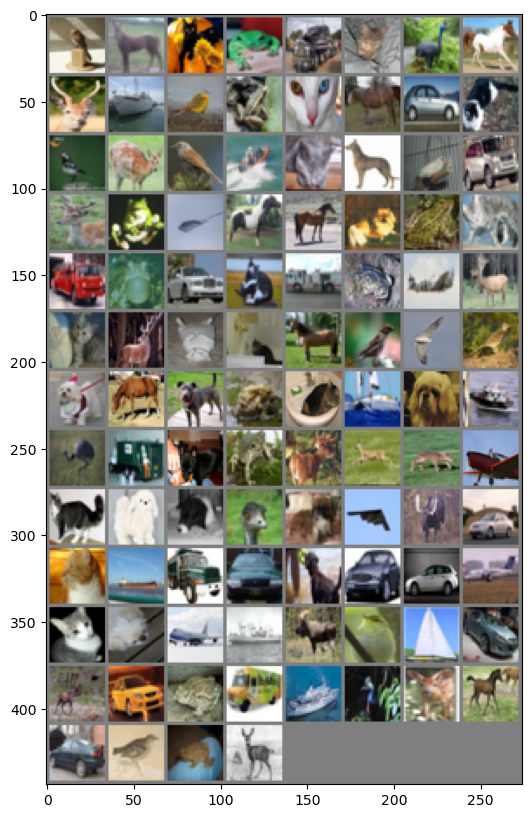

 bird horse   cat  frog truck   cat  bird horse


In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


### Архитектура нейронной сети

Для простоты и демонстрации принципа сжатия слоёв нейронных сетей рассмотрим архитектуру, состоящую только из полносвязных слоёв (то есть линейных преобразований) и стандартных ReLU-нелинейностей. Опять же для наглядности выбрали размерность 1000 для полносвязных слоёв. 

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.fc6 = nn.Linear(1000, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)

        y = self.fc2(x)
        y = self.ReLU(y)
        y = self.fc3(y)

        x1 = self.ReLU(y + x)

        
        y1 = self.fc4(x1)
        y1 = self.ReLU(y1)
        y1 = self.fc5(y1)

        x2 = self.ReLU(x1 + y1)

        z = self.fc6(x2)
        return F.log_softmax(z, dim=1)

#### Функции для обучения и тестирования результата после каждого прохождения всех данных 

In [4]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [5]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Зададим параметры обучения и вывода промежуточных результатов

In [6]:
log_interval = 50
epochs = 7

### Запускаем обучение с помощью метода оптимизации [Adam](https://arxiv.org/pdf/1412.6980.pdf%20%22%20entire%20document) 
Если у вас не очень мощный ноутбук, то придётся подождать некоторое время. 

In [12]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, epochs + 1):
    train(model,  train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.311656
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.689571
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.659077
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.551364
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.461634
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.736933
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.679359
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.602599
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.339175
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.579457

Test set: Average loss: 1.4782, Accuracy: 4753/10000 (48%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.575880
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.321099
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.422814
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.289273
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.337261
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.404286
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.378523
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.471279
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.279549
T

In [13]:
torch.save(model, 'svd_seminar_model.pth')

In [41]:
model = torch.load('svd_seminar_model.pth')

- Вычисляем SVD для матрицы $1000 \times 1000$, которая соответствует любому слою подходящего размера обученной нейросети. Покажем на графике убывание сингулярных чисел. Какой вывод можно сделать?



In [8]:
W = model.state_dict()['fc1.weight']
U, S, V = np.linalg.svd(W, full_matrices=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


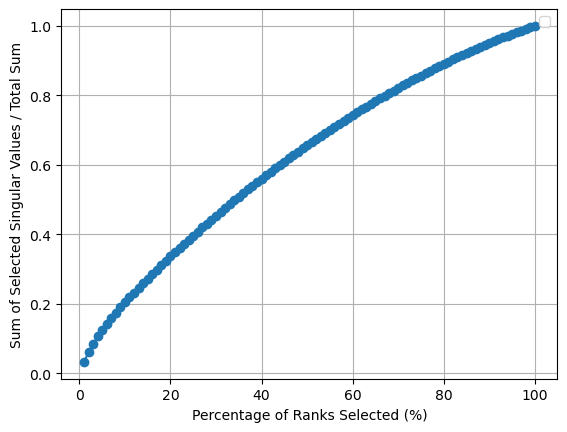

In [9]:
total_singular_value_sum = np.sum(S)

percentages = np.arange(1, 101, 1)  # From 1% to 100%
ratios = []

for percent in percentages:
    k = int(len(S) * (percent / 100))  # Number of ranks selected
    ratio = np.sum(S[:k]) / total_singular_value_sum
    ratios.append(ratio)

# Plotting
plt.plot(percentages, ratios, marker='o')
plt.xlabel('Percentage of Ranks Selected (%)')
plt.ylabel('Sum of Selected Singular Values / Total Sum')
plt.grid(True)
plt.legend()


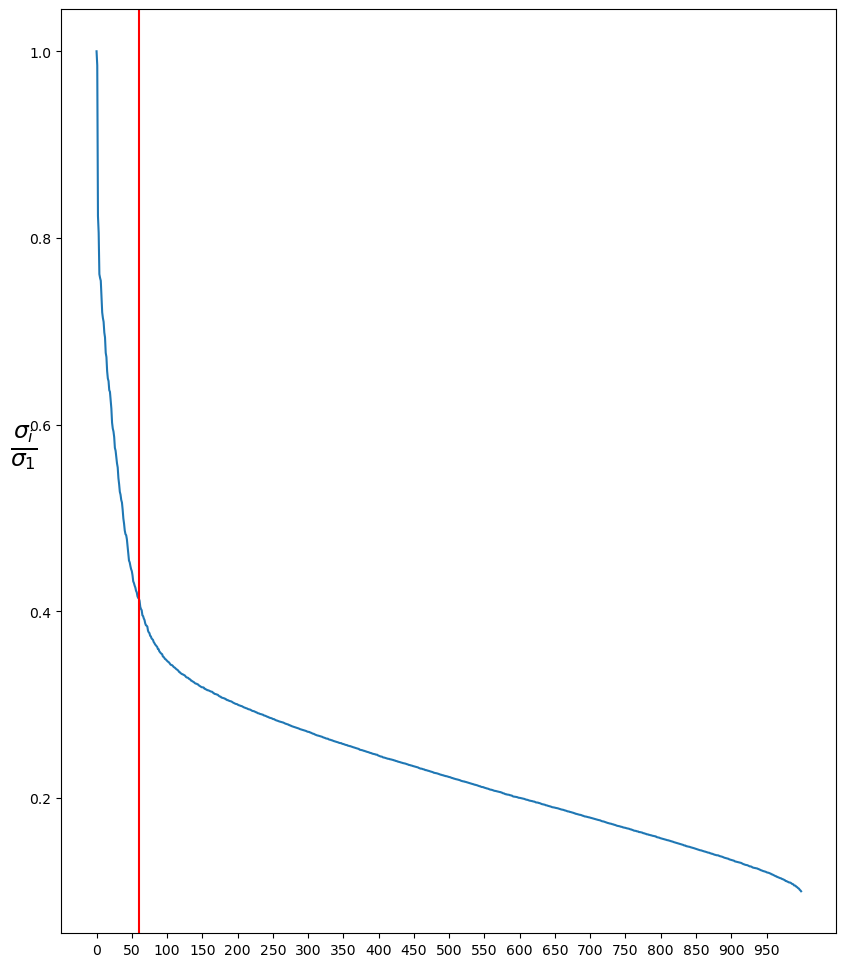

In [10]:
plt.figure(figsize = (10, 12))
plt.plot(S / S[0])
plt.axvline(x=60, color='r')
plt.xticks(np.arange(0, 1000, 50))
plt.ylabel(r"$\frac{\sigma_i}{\sigma_1}$", fontsize=24, rotation=0)
plt.show()


- Создадим модель (аналогично классу ```Net```), которая на вход будет принимать экземпляр класса ```Net```, ранг $r > 0$ и список индексов слоёв, веса которых будут сжиматься. Эта модель будет сжимать некоторые полносвязные слои (индексы которых переданы на вход) с помощью SVD разложения, из которого берутся только первые $r$ компонент. Также функция ```forward``` будет эффективно реализована с использованием сжатого представления полносвязных слоёв, а в остальном полностью повторять эту же функцию для несжатой обученной сети.



In [18]:
class TruncatedModel(nn.Module):

    def __init__(self, Net, r=None, indexes=None):
        '''
        Net: object of class Net
        r: int, rank of truncated svd
        indexes: list of int, number of linear layers to truncate. starts from 1
        '''


        super(TruncatedModel, self).__init__()
        self.net = Net
        self.r = r
        self.indexes = indexes
        self.ReLU = torch.nn.ReLU()
        self.n_params = 0
        self.layers_computed = []
        
        self.truncated_dict = {}

        if r is not None:
            for idx in indexes:
                self.truncate_layer(idx)


    
    def truncate_layer(self, layer_name):
        proper_name = 'fc'+str(layer_name)
        W = self.net.state_dict()[proper_name+'.weight']
        bias = self.net.state_dict()[proper_name+'.bias']

        U, S, Vt = np.linalg.svd(W, full_matrices=False)        

        U_truncated = torch.from_numpy(U[:, :self.r])
        S_truncated = S[:self.r]
        Vt_truncated = Vt[:self.r, :]

        SVt = torch.from_numpy(np.diag(S_truncated)@Vt_truncated)

        U = torch.nn.Parameter(data = U_truncated)
        SVt = torch.nn.Parameter(data = (SVt))

        self.register_parameter(proper_name + '_U', U)
        self.register_parameter(proper_name + '_SVt', SVt)


        self.truncated_dict[layer_name] = (U, SVt, bias)

        

    def fc_compressed(self, x, layer_name):

        if layer_name in self.indexes:
            return self.compute_compressed(x, layer_name)
        else:
            proper_name = 'fc'+str(layer_name)

            W = self.net.state_dict()[proper_name+'.weight']
            if layer_name not in self.layers_computed:
                self.n_params += W.size(0)*W.size(1)
                self.layers_computed.append(layer_name)
            

            return getattr(model, proper_name)(x)

    def compute_compressed(self, x, layer_name):
        U, SVt, bias = self.truncated_dict[layer_name]

        #print(SVt.size())
        if layer_name not in self.layers_computed:
            self.n_params += U.size(0)*U.size(1) + SVt.size(0)*SVt.size(1)
            self.layers_computed.append(layer_name)



        out = (x @ SVt.T) @ U.T + bias.expand(x.shape[0], -1)

        return out



    def forward(self, x):

        x = self.fc_compressed(x.view(-1, 3 * 32*32), 1)
        x = self.ReLU(x)

        y = self.fc_compressed(x, 2)
        y = self.ReLU(y)
        y = self.fc_compressed(y, 3)

        x1 = self.ReLU(y + x)

        
        y1 = self.fc_compressed(x1, 4)
        y1 = self.ReLU(y1)
        y1 = self.fc_compressed(y1, 5)

        x2 = self.ReLU(x1 + y1)

        z = self.fc_compressed(x2, 6)
        out = F.log_softmax(z, dim=1)

        return out



In [25]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))

    accuracy = correct / len(test_loader.dataset)
    return accuracy


- Построим зависимость точности предсказания на тестовой выборе от количества параметров, которое необходимо для этого. Это количество, очевидно, некоторым образом зависит от заданного ранга сжатия $r$. Также построим зависимость времени вычисления от ранга сжатия.

In [15]:
import time
from tqdm import tqdm

In [19]:
compress_layers = [[1], [2], [3], [1,2], [2,3], [1,2,3,4]]

ranks = [10, 50, 70, 100]

results_time = {}
results_accuracy = {}
results_params = {}

for cl in tqdm(compress_layers):
    res_time = []
    res_acc = []
    res_params = []

    for r in ranks:
        
        tr_model = TruncatedModel(model, r = r, indexes=cl)

        

        start = time.time()
        acc = test(tr_model, test_loader)
        end = time.time()

        n_params = tr_model.n_params
        
        res_time.append(end-start)

        res_params.append(n_params)
        res_acc.append(acc)

    results_params[tuple(cl)] = res_params
    results_accuracy[tuple(cl)] = res_acc
    results_time[tuple(cl)] = res_time

100%|██████████| 6/6 [01:41<00:00, 16.83s/it]


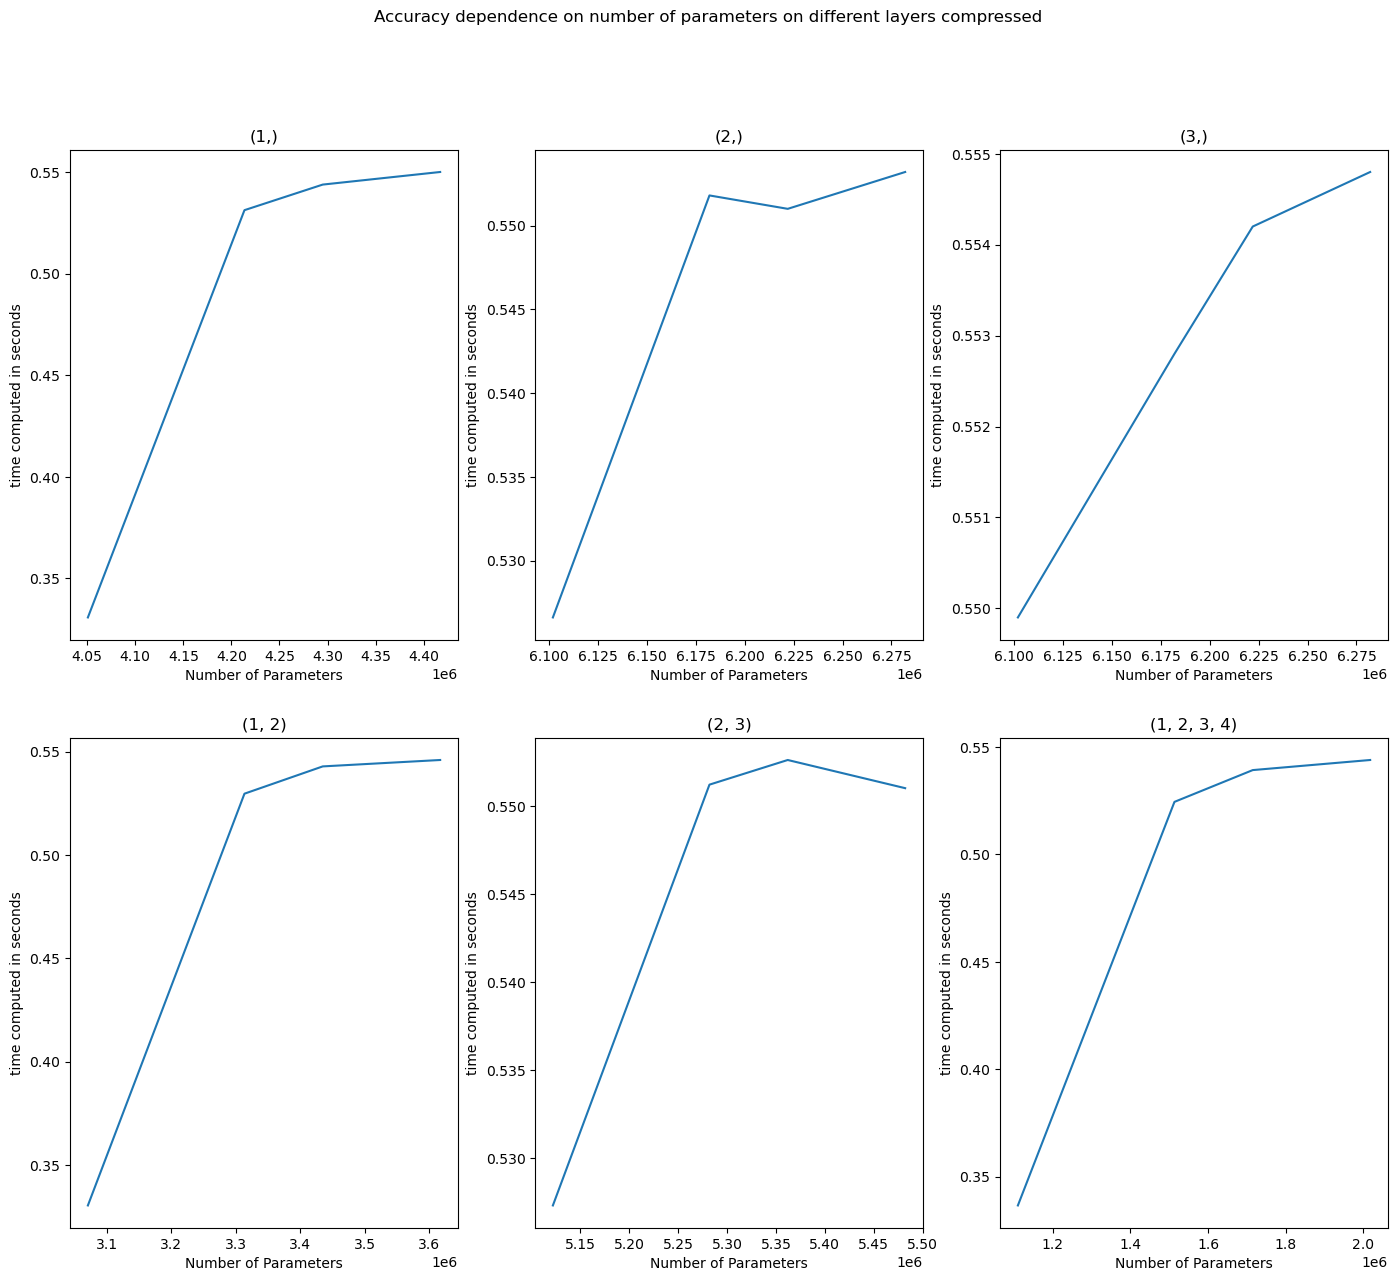

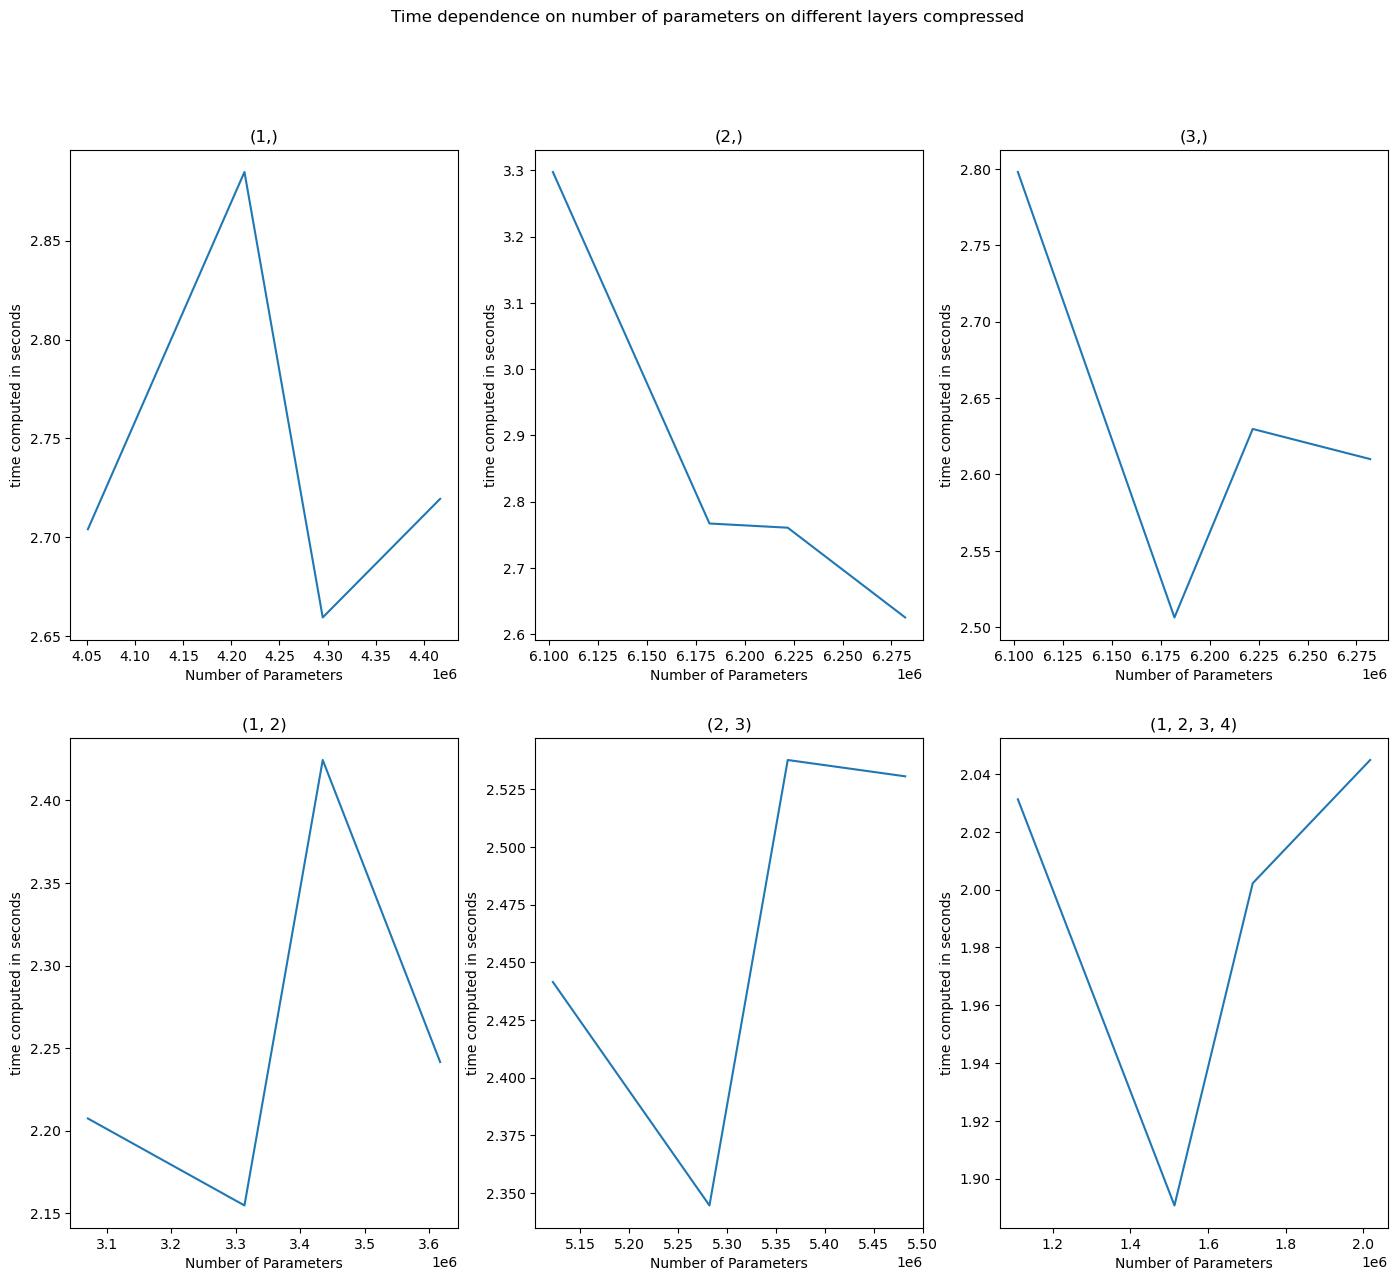

In [36]:

plt.subplots(2,3, figsize=(17,14))
plt.suptitle('Accuracy dependence on number of parameters on different layers compressed')
for i in range(1, 7): 
    plt.subplot(2, 3, i) 
    cur_key = list(results_accuracy.keys())[i-1]
    values_params = results_params[cur_key]
    values_accuracy = results_accuracy[cur_key]

    plt.plot(values_params, values_accuracy)
    plt.title('{}'.format(cur_key))
    plt.ylabel('time computed in seconds')
    plt.xlabel('Number of Parameters')
    #plt.xticks(ranks)
    #plt.axis("off") # о

plt.show()



plt.subplots(2,3, figsize=(17,14))
plt.suptitle('Time dependence on number of parameters on different layers compressed')
for i in range(1, 7):
    plt.subplot(2, 3, i) 

    cur_key = list(results_accuracy.keys())[i-1]
    values_params = results_params[cur_key]
    values_time = results_time[cur_key]

    plt.plot(values_params, values_time)
    plt.title('{}'.format(cur_key))
    plt.ylabel('time computed in seconds')
    plt.xlabel('Number of Parameters')
    #plt.xticks(ranks)
    #plt.axis("off") # о

plt.show()

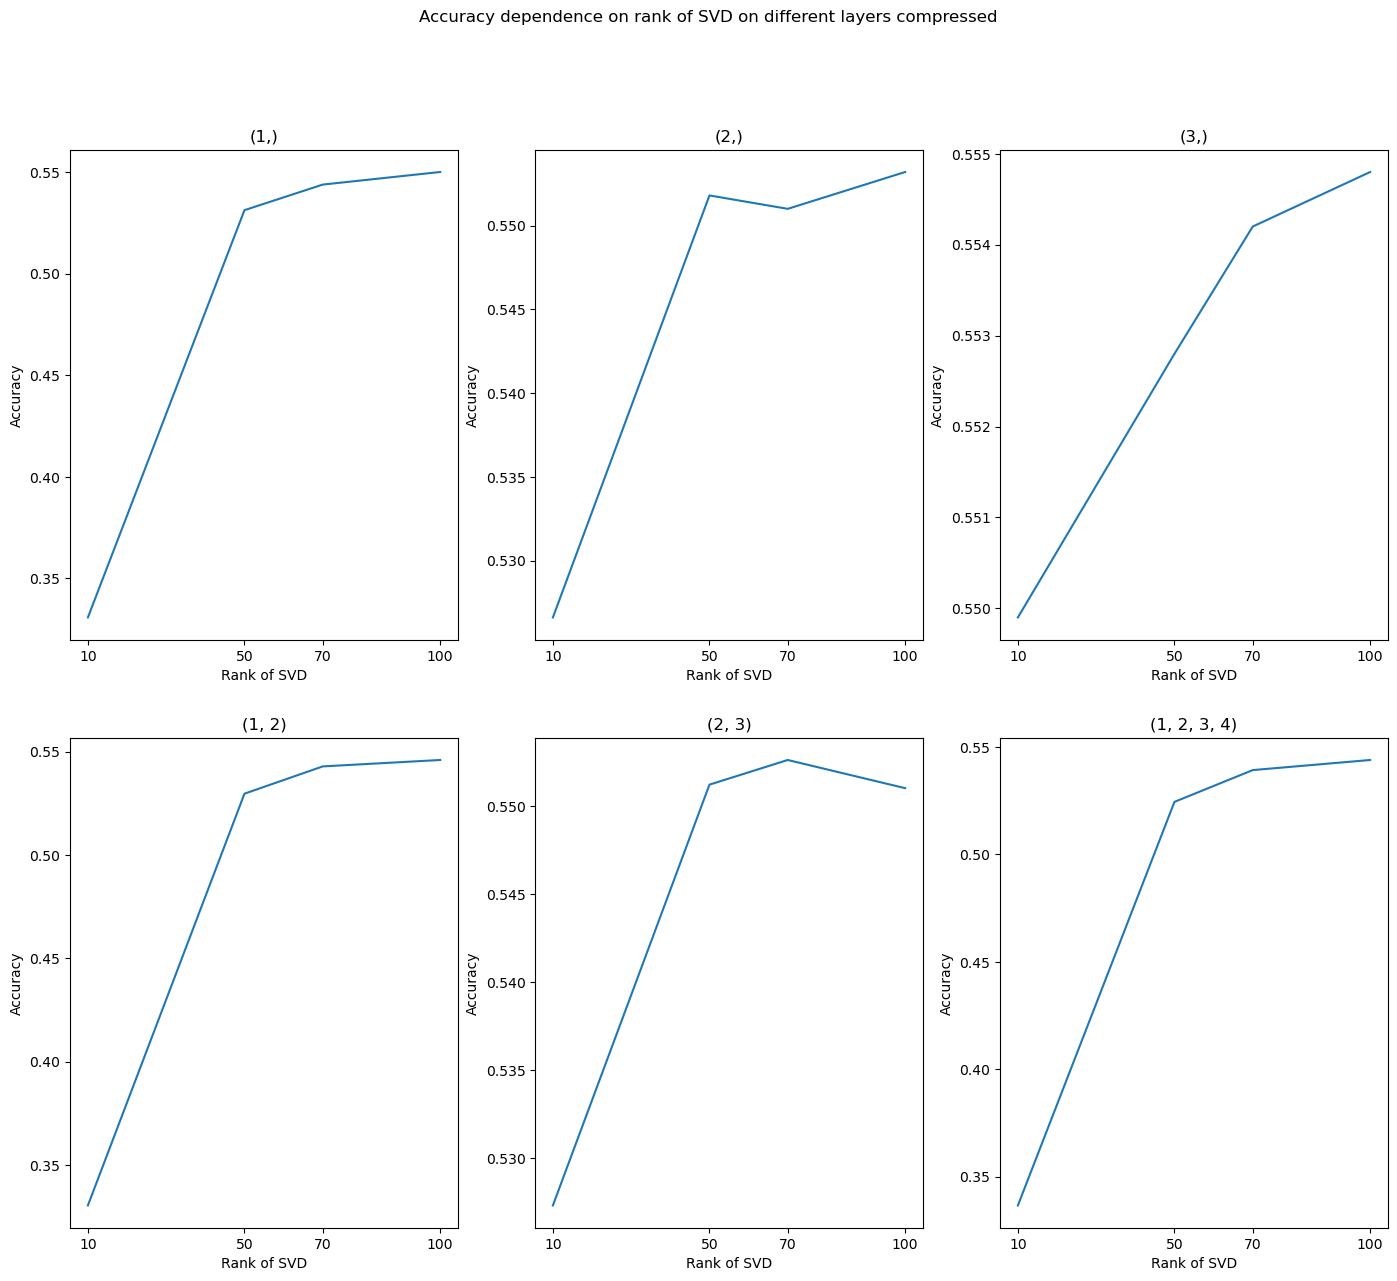

In [35]:

plt.subplots(2,3, figsize=(17,14))
plt.suptitle('Accuracy dependence on rank of SVD on different layers compressed')
for i in range(1, 7):
    plt.subplot(2, 3, i)

    cur_key = list(results_accuracy.keys())[i-1]
    values = results_accuracy[cur_key]
    plt.plot(ranks, values)
    plt.title('{}'.format(cur_key))
    plt.xticks(ranks)
    plt.ylabel('Accuracy')
    plt.xlabel('Rank of SVD')
    #plt.axis("off") # о

plt.show()

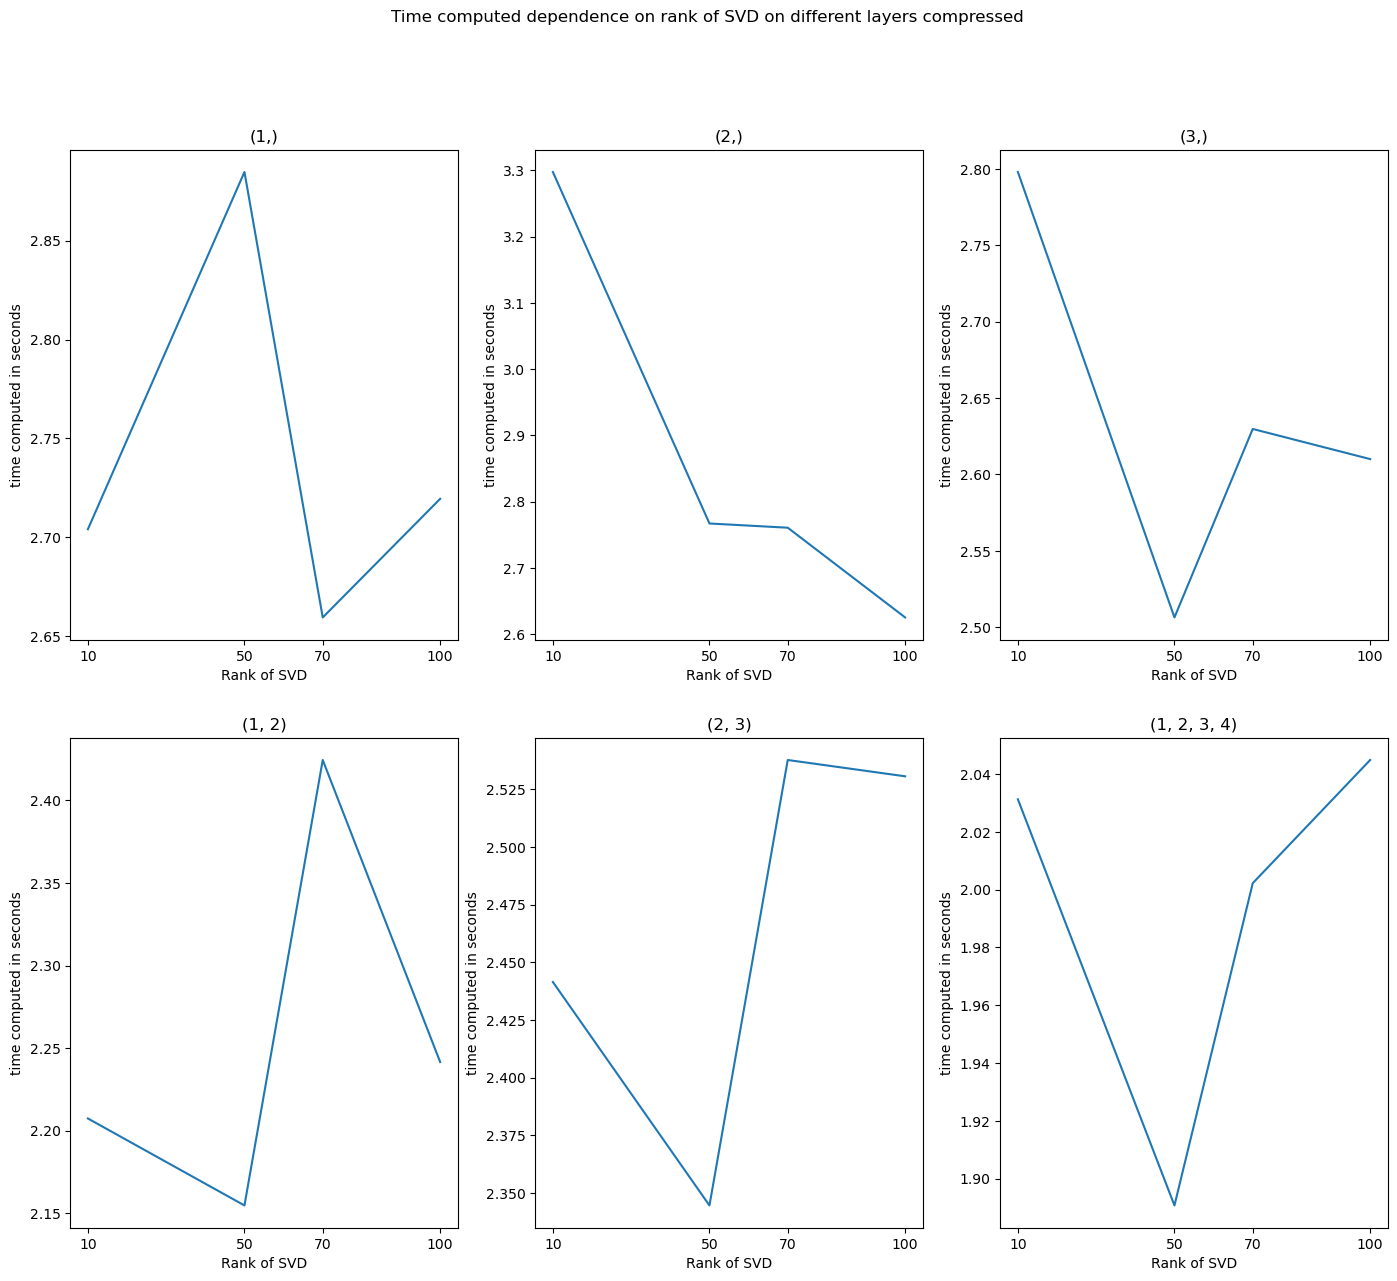

In [34]:
plt.subplots(2,3, figsize=(17,14))
plt.suptitle('Time computed dependence on rank of SVD on different layers compressed')
for i in range(1, 7): 
    plt.subplot(2, 3, i)
    cur_key = list(results_time.keys())[i-1]
    values = results_time[cur_key]
    plt.plot(ranks, values)
    plt.title('{}'.format(cur_key))
    plt.xticks(ranks)
    plt.ylabel('time computed in seconds')
    plt.xlabel('Rank of SVD')
    #plt.axis("off") # о

plt.show()

### Fine-tuning

- Поскольку в нашей модели, которая использует сжатое представление линейных слоёв, параметрами являются матрицы, полученные из SVD соответствующих линейных слоёв, то их также можно оптимизировать.

In [42]:
tr_model = TruncatedModel(model, 50, [1,2,3,4])
optimizer = optim.Adam(model.parameters(), lr=1e-4)

init_acc = test(tr_model, test_loader)

In [43]:
epochs = 5
acc_list = []

for epoch in range(1, epochs + 1):
    train(tr_model,  train_loader, optimizer, epoch)
    acc = test(tr_model, test_loader)
    acc_list.append(acc)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.105282
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.290810
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.314310
Train Epoch: 1 [15000/50000 (30%)]	Loss: 0.830843
Train Epoch: 1 [20000/50000 (40%)]	Loss: 0.895860
Train Epoch: 1 [25000/50000 (50%)]	Loss: 0.979646
Train Epoch: 1 [30000/50000 (60%)]	Loss: 0.908905
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.032871
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.031821
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.025743
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.930151
Train Epoch: 2 [5000/50000 (10%)]	Loss: 0.953354
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.059248
Train Epoch: 2 [15000/50000 (30%)]	Loss: 0.942070
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.933881
Train Epoch: 2 [25000/50000 (50%)]	Loss: 0.940917
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.240322
Train Epoch: 2 [35000/50000 (70%)]	Loss: 0.951856
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.066481
Train Epoch: 2 [45000/50000 (90%)]	Loss: 0.927637
Train Epoch:

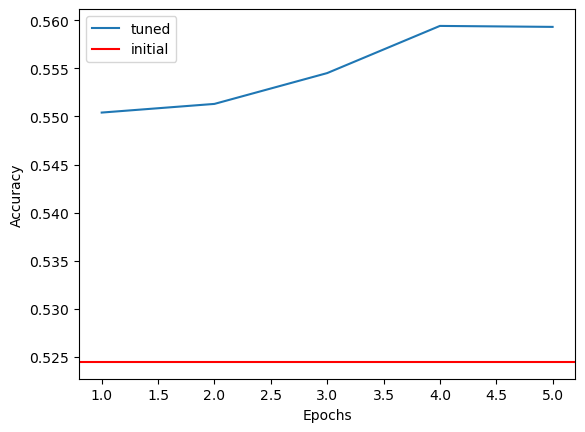

In [46]:
plt.plot(range(1, 6), acc_list, label='tuned')
plt.axhline(y=init_acc, color='r', linestyle='-', label='initial')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()